# GAM requirements in iJL1678b-ME

Code for reproducing panels Figure 2d

## Setup environment

In [1]:
import coralme
from coralme.builder.helper_functions import *
import pickle
import pandas
import os
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sympy
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pickle, tqdm
with open('./published/ecoli/MEModel-step2-ecoli.pkl', 'rb') as infile:
    me = pickle.load(infile)
    
me.add_boundary(me.metabolites.li_c, type = 'sink');
me.optimize(max_mu = 1.0, verbose = True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01
Read LP format model from file /tmp/tmp18e3m_qs.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp8o8eslx_.lp
Reading time = 0.01 seconds
: 1660 rows, 4754 columns, 17902 nonzeros
Read LP format model from file /tmp/tmp1b9ep32l.lp
Reading time = 0.01 seconds
: 1810 rows, 5220 columns, 17878 nonzeros
The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Optimal
        3	0.8750000000000000	Not feasible
        4	0.8125000000000000	Optimal
        5	0.8437500000000000	No

True

In [3]:
# construct the LP problem to accelerate feasibility checks
lp = me.construct_lp_problem(lambdify = True)

In [4]:
# 30min, 15 CPUs
def get_feas(mu):
    me.feasibility({ me.mu : mu }, **{'lp' : lp})
    return me.solution

opt = me.solution.objective_value
mus = np.arange(0.01, opt-0.1, 0.01)

import multiprocessing
with multiprocessing.Pool(multiprocessing.cpu_count()-1) as pool:
    fluxes = pool.map(get_feas, mus)

In [5]:
types = set()
for rxn in me.reactions:
    types.add(type(rxn))
types = sorted(types, key = lambda x: str(x))
# types

In [6]:
import coralme, sympy

directly_modeled = {}

def get_reactions(met, rxn_type):
    value = sympy.Float(0)
    reactions = []
    
    for rxn in met.reactions:
        if isinstance(rxn, (rxn_type)) and rxn.metabolites[met] < 0:
            reactions.append(rxn.id)
            value += rxn.metabolites[met] * fluxes[idx][rxn.id]
    
    return value, reactions

for rxn_type in types:
    directly_modeled[rxn_type] = {}
    for met in [ 'atp_c', 'utp_c', 'gtp_c', 'ctp_c', 'datp_c', 'dttp_c', 'dgtp_c', 'dctp_c', ]:
        directly_modeled[rxn_type][met] = []
        for idx, mu in enumerate(mus):
            value, reactions = get_reactions(me.metabolites.get_by_id(met), rxn_type)
            value = value.subs({ me.mu : me.solution.objective_value })
            directly_modeled[rxn_type][met].append(value)
            
df_directly_modeled = pandas.DataFrame.from_dict(directly_modeled)

In [7]:
from scipy.stats import linregress

filter_out = [ 
    coralme.core.reaction.MEReaction, 
    coralme.core.reaction.MetabolicReaction,
    coralme.core.reaction.GenericFormationReaction
]

slopes = df_directly_modeled.applymap(lambda x: linregress(mus, [ -1. * float(x) for x in x])[0])
slopes = slopes.loc[:, ~slopes.columns.isin(filter_out)]

slopes.columns = [
    'Complex Formation', 
    'PostTranslation', 
    'Summary Variables', 
    'Transcription', 
    'Translation', 
    'tRNA Charging'
]

slopes.index = ['ATP', 'UTP', 'GTP', 'CTP', 'dATP', 'dTTP', 'dGTP', 'dCTP']
slopes = slopes.replace(0, np.nan)

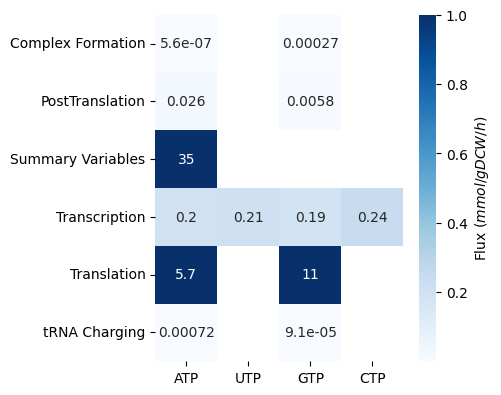

In [8]:
import seaborn

fig, ax = plt.subplots(1, 1, figsize = (4*1, 3*1.5), dpi = 100)

cg = seaborn.heatmap(
    slopes.T[['ATP', 'UTP', 'GTP', 'CTP']], 
    annot = True, cmap = 'Blues', vmax = 1., ax = ax,
    cbar_kws = {'label': 'Flux ($mmol / gDCW / h$)'})

plt.savefig('figures/GAM_calculation.svg',format='SVG')

In [11]:
np.round(slopes.loc['ATP', 'Translation'], 2) + np.round(slopes.loc['GTP', 'Translation'], 2)

17.09

In [10]:
slopes.loc['ATP', 'Translation'] + slopes.loc['GTP', 'Translation']

17.08632849027311